# Data Loading And Processing

In [361]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [362]:
df = pd.read_csv("/kaggle/input/food-delivery-time-prediction/Food_Delivery_Times.csv")
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [363]:
print(f'Data Sanity:\n{df.shape}\n')
print(f'Nulls:\n{df.isna().sum()}\n')
print(f'Duplicated:\n{df.duplicated().sum()}\n')
print(f'Dtypes:\n{df.dtypes}')

Data Sanity:
(1000, 9)

Nulls:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

Duplicated:
0

Dtypes:
Order_ID                    int64
Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object


In [364]:
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
df['Weather'] = df['Weather'].astype('category')
df['Traffic_Level'] = df['Traffic_Level'].fillna(df['Traffic_Level'].mode()[0])
df['Traffic_Level'] = df['Traffic_Level'].astype('category')
df['Time_of_Day'] = df['Time_of_Day'].fillna(df['Time_of_Day'].mode()[0])
df['Time_of_Day'] = df['Time_of_Day'].astype('category')
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].mean())
df['Vehicle_Type'] = df['Vehicle_Type'].astype('category')
df['Total_time_min'] = df['Preparation_Time_min'] + df['Delivery_Time_min']

In [365]:
cats = df.select_dtypes(include = 'category').columns
nums = df.select_dtypes(include = 'number').columns

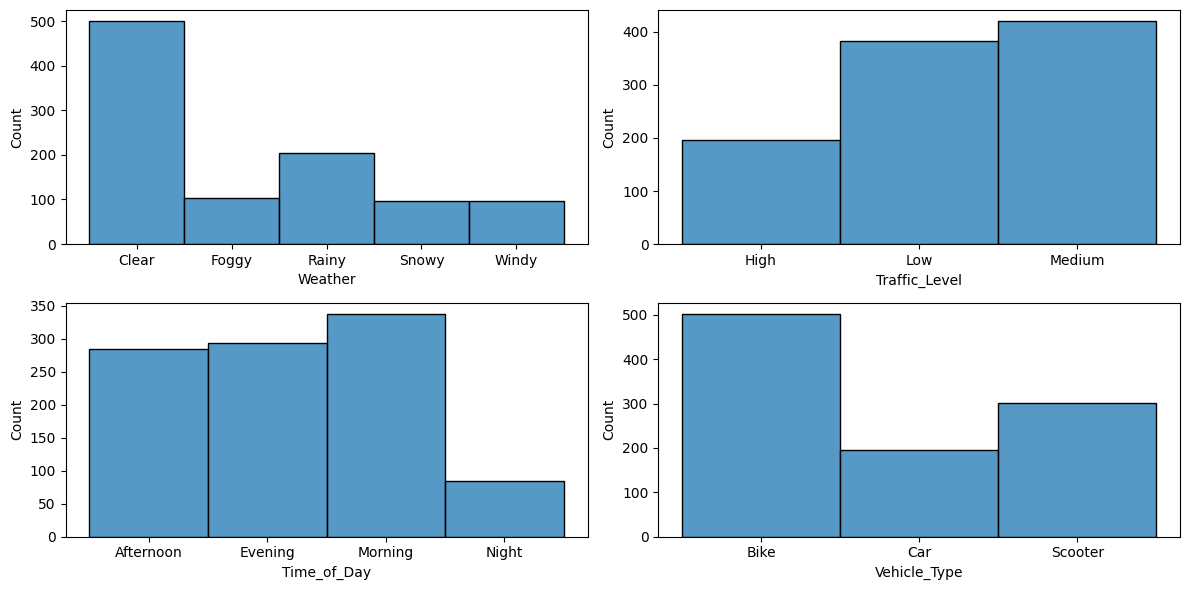

In [366]:
plt.figure(figsize=(12,6))
for i, col in enumerate(cats):
    plt.subplot(2,2,i+1)
    sns.histplot(df[col])
plt.tight_layout()
plt.show()

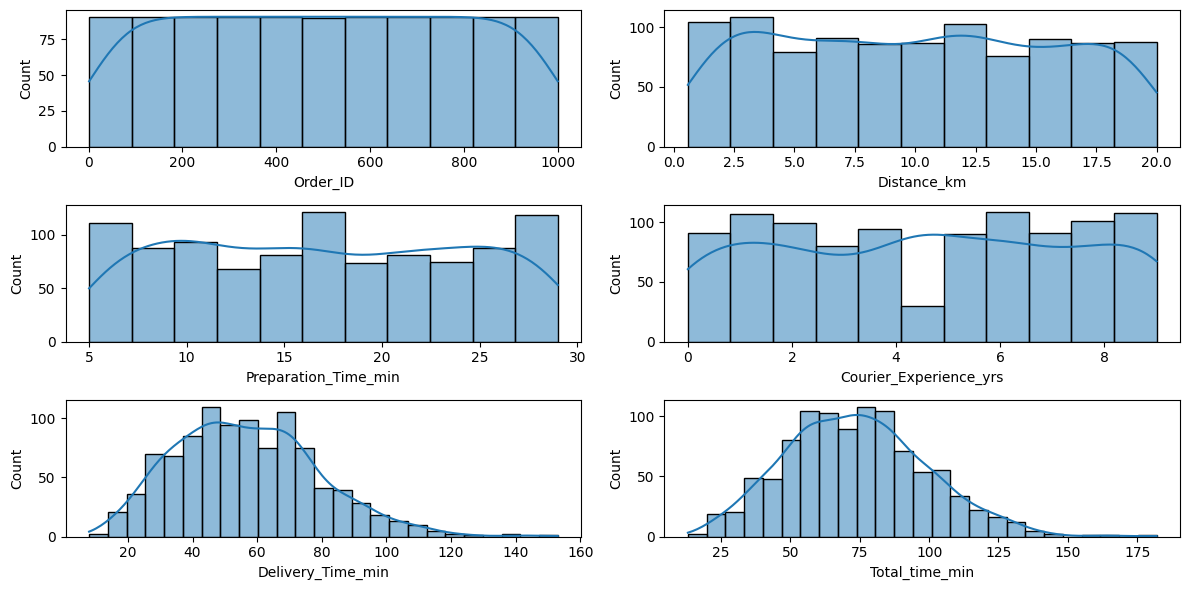

In [367]:
plt.figure(figsize=(12,6))
for i, col in enumerate(nums):
    plt.subplot(3,2,i+1)
    sns.histplot(df[col], kde = True)
plt.tight_layout()
plt.show()

# Exploratory Data Analysis

In [368]:
df_new = df.copy()

df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Order_ID,1000.0,500.500000,288.819436,1.00,250.750,500.500000,750.2500,1000.00
Distance_km,1000.0,10.059970,5.696656,0.59,5.105,10.190000,15.0175,19.99
Preparation_Time_min,1000.0,16.982000,7.204553,5.00,11.000,17.000000,23.0000,29.00
Courier_Experience_yrs,1000.0,4.579381,2.870301,0.00,2.000,4.579381,7.0000,9.00
Delivery_Time_min,1000.0,56.732000,22.070915,8.00,41.000,55.500000,71.0000,153.00
Total_time_min,1000.0,73.714000,25.234401,13.00,55.000,73.000000,89.0000,182.00


In [369]:
le = LabelEncoder()
df_new['Traffic_Level'] = le.fit_transform(df_new['Traffic_Level'])
df_new['Weather'] = le.fit_transform(df_new['Weather'])
df_new['Time_of_Day'] = le.fit_transform(df_new['Time_of_Day'])
df_new['Vehicle_Type'] = le.fit_transform(df_new['Vehicle_Type'])

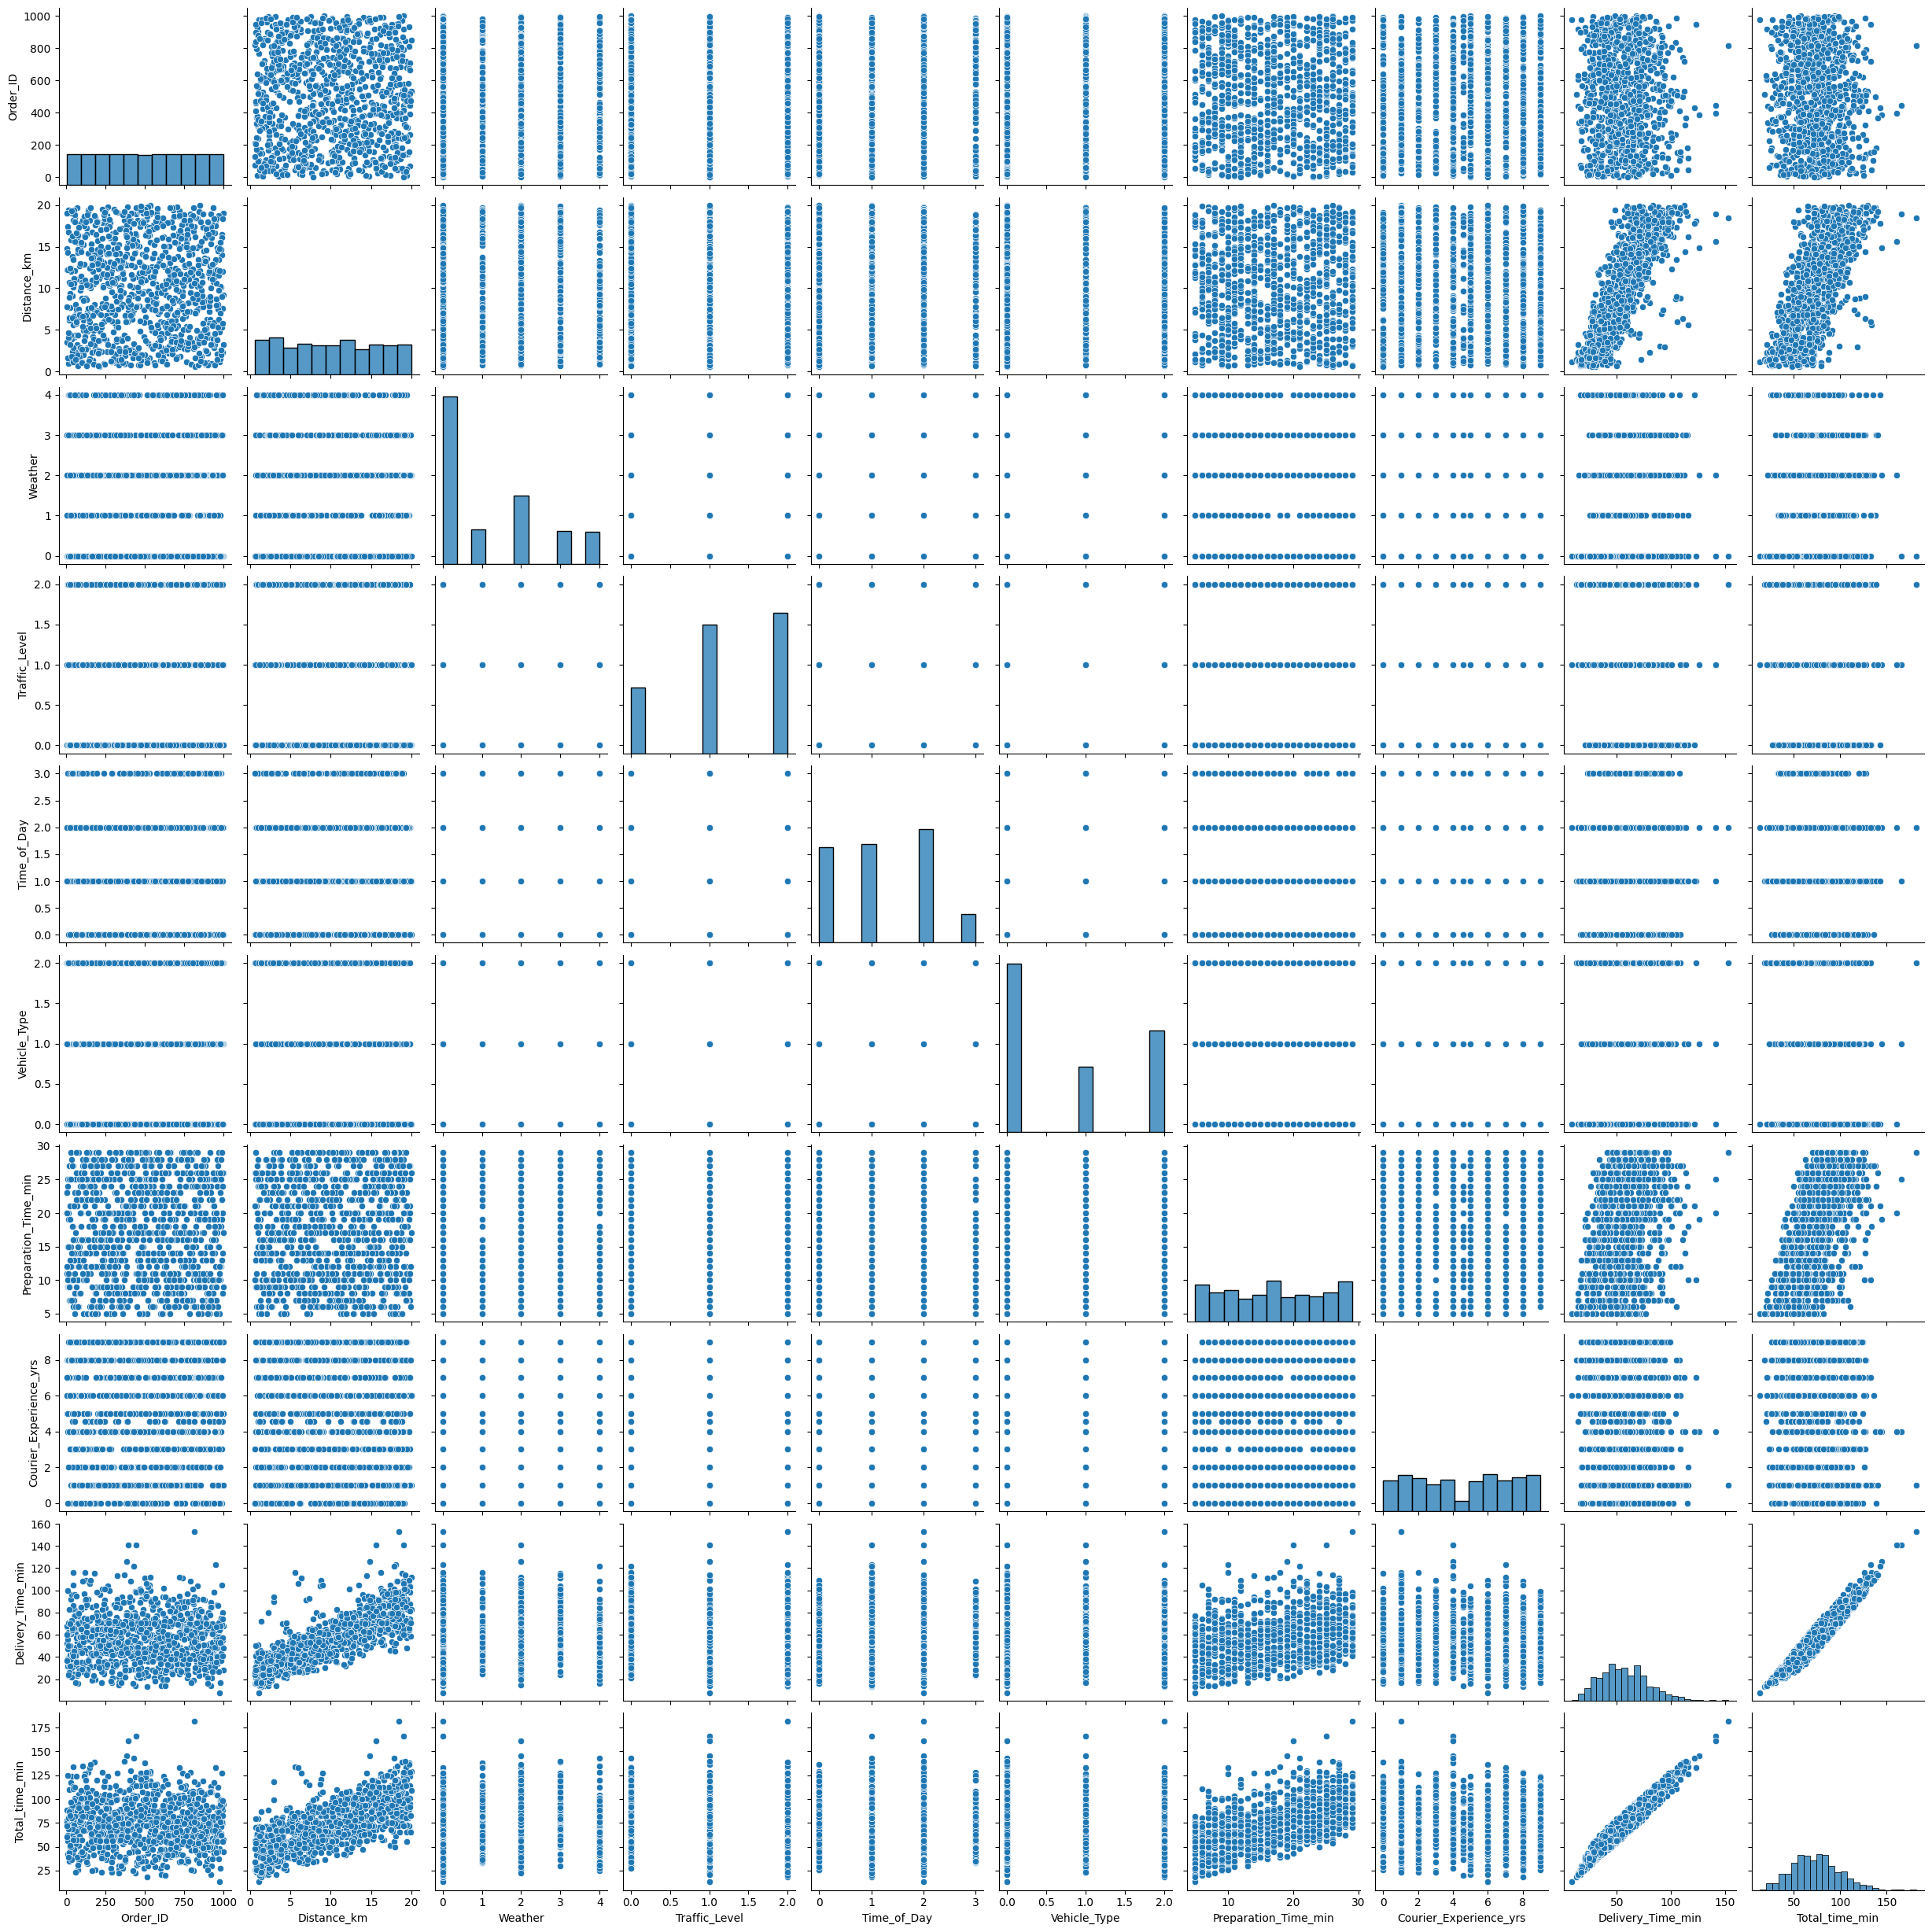

In [370]:
sns.pairplot(df_new)

<Axes: >

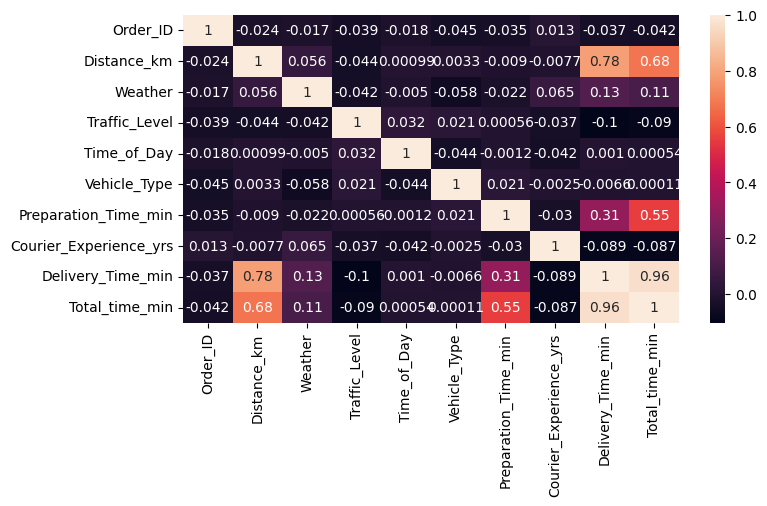

In [371]:
correlation = df_new.corr()
plt.figure(figsize=(8,4))
sns.heatmap(correlation, annot = True)

# Insight

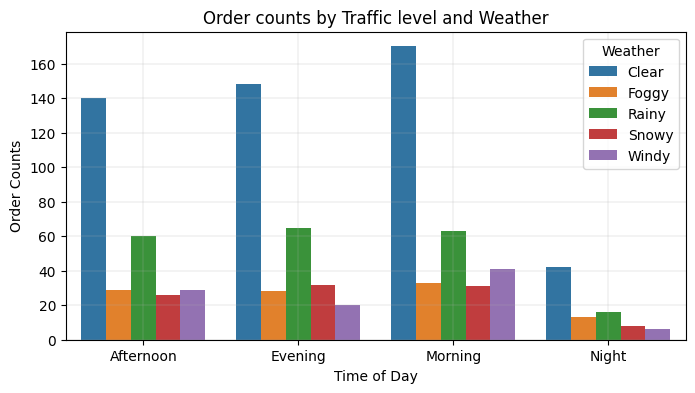

In [372]:
plt.figure(figsize=(8,4))
sns.countplot(df, x = 'Time_of_Day', hue = 'Weather')
plt.title("Order counts by Traffic level and Weather")
plt.xlabel("Time of Day")
plt.ylabel("Order Counts")
plt.grid(linewidth = 0.2)
plt.show()

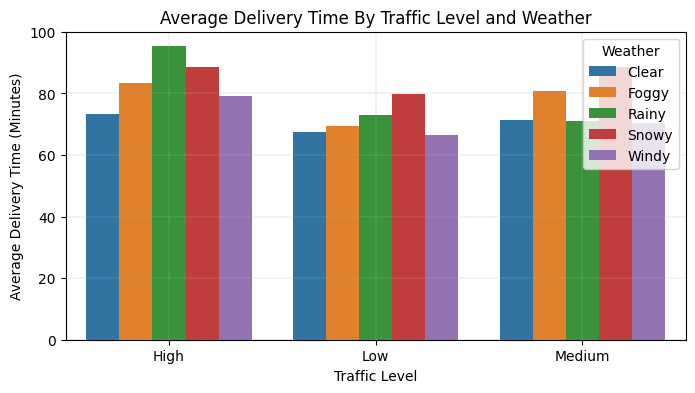

In [373]:
pivot = df.groupby(['Traffic_Level', 'Weather'])['Total_time_min'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(pivot, x = 'Traffic_Level', y = 'Total_time_min', hue = 'Weather')
plt.title("Average Delivery Time By Traffic Level and Weather")
plt.xlabel("Traffic Level")
plt.ylabel("Average Delivery Time (Minutes)")
plt.grid(linewidth = 0.2)
plt.show()

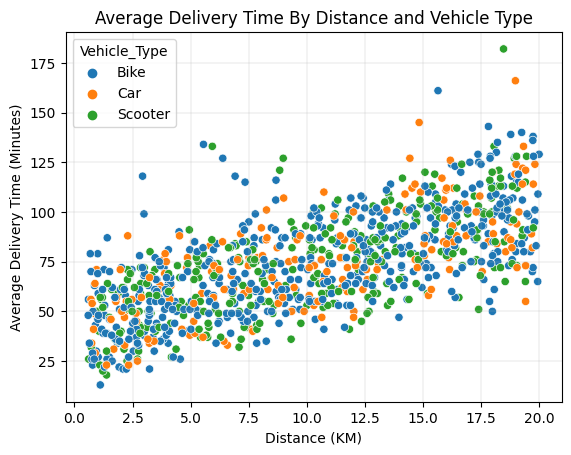

In [374]:
sns.scatterplot(df, x = 'Distance_km', y = 'Total_time_min', hue = 'Vehicle_Type')
plt.title("Average Delivery Time By Distance and Vehicle Type")
plt.xlabel("Distance (KM)")
plt.ylabel("Average Delivery Time (Minutes)")
plt.grid(linewidth = 0.2)
plt.show()

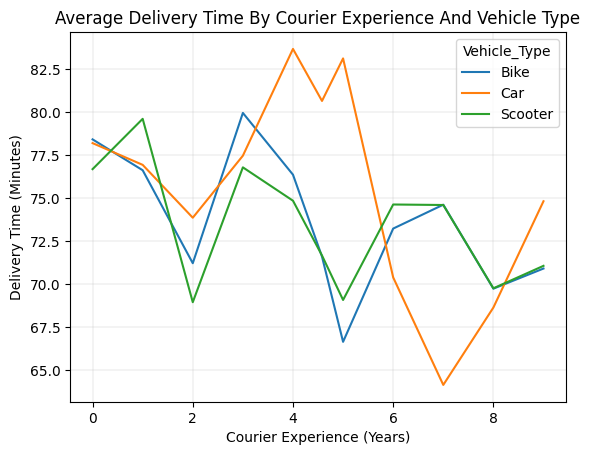

In [375]:
pivot = df.groupby(['Courier_Experience_yrs', 'Vehicle_Type'])['Total_time_min'].mean().reset_index()
sns.lineplot(pivot, x = 'Courier_Experience_yrs', y = 'Total_time_min', hue = 'Vehicle_Type')
plt.title("Average Delivery Time By Courier Experience And Vehicle Type")
plt.xlabel("Courier Experience (Years)")
plt.ylabel("Delivery Time (Minutes)")
plt.grid(linewidth = 0.2)
plt.show()

# Modelling

In [376]:
X = df_new.drop(['Order_ID', 'Total_time_min'], axis = 1)
y = df_new['Total_time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

In [377]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [378]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled,y_train)

RandomForestRegressor()

In [379]:
y_pred = rf.predict(X_test_scaled)

In [380]:
score = r2_score(y_test, y_pred)
print(f'R2 Score :{score}')

R2 Score :0.997336894474036
